# Multi class Amazon product reviews classification using deep learning

In [89]:
# Import necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
import string 
import warnings
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive/multi_class_text_classification

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
'Copy of delete now.ipynb'
 deep_learning_multi_class_text_classification.ipynb
'delete now.ipynb'
 machine_learning_multi_class_text_classification.ipynb
 text_cls
 Transformer_multi_class_text_classification.ipynb


In [3]:
# Install spacy en_core_web_lg and fastText
!python -m spacy download en_core_web_lg
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText/
!sudo python setup.py install
%cd ..

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
fatal: destination path 'fastText' already exists and is not an empty directory.
/content/fastText
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing python/fasttext_module/fasttext.egg-info/PKG-INFO
writing dependency_links to python/fasttext_module/fasttext.egg-info/dependency_links.txt
writing requirements to python/fasttext_module/fasttext.egg-info/requires.txt
writing top-level names to python/fasttext_module/fasttext.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'python/fasttext_module/fasttext.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
runn

In [4]:
# Read data
df = pd.read_csv('/content/gdrive/MyDrive/multi_class_text_classification/text_cls/train_40k.csv')[['Text','Cat1']]
df.head()

,Text,Cat1
0,The description and photo on this product need...,grocery gourmet food
1,This was a great book!!!! It is well thought t...,toys games
2,"I am a first year teacher, teaching 5th grade....",toys games
3,I got the book at my bookfair at school lookin...,toys games
4,Hi! I'm Martine Redman and I created this puzz...,toys games


In [5]:
df.shape

(40000, 2)

In [6]:
# Drop duplicates
df.drop_duplicates(inplace=True)
df.shape

(39512, 2)

In [7]:
df['Cat1'].value_counts()

toys games              10246
health personal care     9524
beauty                   5722
baby products            5602
pet supplies             4820
grocery gourmet food     3598
Name: Cat1, dtype: int64

In [8]:
# Balance all classes
df = df.groupby('Cat1').sample(n=3598).reset_index(drop=True)
df

,Text,Cat1
0,"M child only chews on the ring and ""stem"" of t...",baby products
1,These diapers are great for my 2 year old. We ...,baby products
2,I understand the problems with the water measu...,baby products
3,"Although a little pricey, we think this backpa...",baby products
4,This hand pump was really a work-out for my ha...,baby products
...,...,...
21583,We got this for our 20 month old daughter. I t...,toys games
21584,I bought this for my niece. It arrived on time...,toys games
21585,My 18 month old grandson will be thrilled with...,toys games
21586,I thought my 8 yr old would be too big for thi...,toys games


In [9]:
# load en_core_web_lg
import spacy
nlp = spacy.load('en_core_web_lg')

In [10]:
def clean_text(sentence):
  """
  Convert to lowercase and remove stopwords and punctuation
  """
  doc = nlp(sentence)

  tokens = []
  for token in doc:
      if token.lemma_ != "-PRON-":
          temp = token.lemma_.lower().strip()
      else:
          temp = token.lower_
      tokens.append(temp)

  cleaned_tokens = []
  for token in tokens:
      if token not in STOP_WORDS and token not in punctuation:
          cleaned_tokens.append(token)
  return ' '.join(cleaned_tokens)

In [11]:
# clean text
df_corpus = df['Text'].apply(clean_text)
df_corpus

0        m child chew ring stem product nuk pacifier bi...
1        diaper great 2 year old leaking issue soft hug...
2        understand problem water measurement practice ...
3        little pricey think backpack worth money diffe...
4        hand pump work hand frustrating pump hand caus...
                               ...                        
21583    20 month old daughter think little advanced ti...
21584    buy niece arrive time perfect condition sure o...
21585    18 month old grandson thrill toy buy plastic s...
21586    think 8 yr old big adventure wrong weigh 78 po...
21587    son peek ball adore young 1 favourite set tact...
Name: Text, Length: 21588, dtype: object

In [12]:
# create corpus.txt for fasttext training
df_corpus.to_csv('corpus.txt',header=False,index=False)

In [13]:
# tokenize input text
max_words = 20000
keras_tokenizer = Tokenizer(max_words)
keras_tokenizer.fit_on_texts(df_corpus.values)
X = keras_tokenizer.texts_to_sequences(df_corpus.values)
X = pad_sequences(X, maxlen = 100, padding = 'pre')
X.shape

(21588, 100)

In [14]:
# label encode output
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Cat1'])
y.size

21588

In [15]:
# Train test split of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape

((17270, 100), (4318, 100))

In [16]:
# One hot encoding of output required for model
from tensorflow.keras.utils import to_categorical
y_train_cat=to_categorical(y_train,6)
y_test_cat=to_categorical(y_test,6)

In [17]:
y_test_cat[:20]

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

## Create FastText embedding matrix

In [18]:
# train unsupervised fasttext
import fasttext
model = fasttext.train_unsupervised('corpus.txt', dim=200)

In [19]:
model.get_word_vector('model')

array([ 0.39695436, -0.0013567 ,  0.17630842,  0.12532477,  0.04300086,
        0.05720523, -0.2201098 , -0.24552858,  0.5476839 ,  0.08839647,
       -0.12094495,  0.08316619, -0.08813772, -0.10279213, -0.05317117,
        0.4040142 ,  0.3533942 ,  0.33449793, -0.14483148, -0.08932153,
       -0.05726968,  0.1709249 , -0.05733649, -0.06507703,  0.24560559,
       -0.15399398,  0.23648523, -0.05206354, -0.15820614,  0.1393426 ,
       -0.41162303, -0.04681975, -0.32275352, -0.19097045, -0.02266522,
       -0.15534028,  0.10758537, -0.31832412,  0.2165747 , -0.38492382,
        0.19294453,  0.20755725,  0.24923155,  0.05609042, -0.17015176,
       -0.02108843, -0.03482237,  0.2915065 , -0.11821228, -0.17888083,
        0.01657727,  0.140681  ,  0.00221776,  0.12882185, -0.19187553,
        0.2052567 ,  0.20794041, -0.09475227,  0.22262672, -0.13291927,
        0.21608776,  0.12117738, -0.04285025,  0.14166829,  0.11601969,
       -0.31767866, -0.3447092 ,  0.33802563,  0.0348985 ,  0.04

In [20]:
len(keras_tokenizer.word_index)

29437

In [21]:
keras_tokenizer.word_index.items()

dict_items([('use', 1), ('product', 2), ('like', 3), ('love', 4), ('buy', 5), ('good', 6), ('great', 7), ('work', 8), ('time', 9), ('try', 10), ('year', 11), ('find', 12), ('old', 13), ('little', 14), ('look', 15), ('hair', 16), ('day', 17), ('think', 18), ('toy', 19), ('dog', 20), ('month', 21), ('2', 22), ('easy', 23), ('come', 24), ('recommend', 25), ('purchase', 26), ('baby', 27), ('thing', 28), ('price', 29), ('need', 30), ('play', 31), ('want', 32), ('3', 33), ('cat', 34), ('know', 35), ('order', 36), ('way', 37), ('taste', 38), ('small', 39), ('amazon', 40), ('son', 41), ('long', 42), ('box', 43), ('problem', 44), ('feel', 45), ('smell', 46), ('lot', 47), ('week', 48), ('daughter', 49), ('5', 50), ('bottle', 51), ('store', 52), ('nice', 53), ('water', 54), ('1', 55), ('new', 56), ('tea', 57), ('start', 58), ('big', 59), ('skin', 60), ('bag', 61), ('clean', 62), ('review', 63), ('4', 64), ('help', 65), ('game', 66), ('seat', 67), ('right', 68), ('color', 69), ('flavor', 70), ('se

In [22]:
# Create embedding matrix
num_words = min(max_words, len(keras_tokenizer.word_index)+1)
embedding_matrix = np.zeros((num_words,200))
for word, i in keras_tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = model.get_word_vector(word)
    embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(20000, 200)


In [23]:
embedding_matrix[1] == model.get_word_vector('use')

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## Model training

In [109]:
# Import necessary library
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint

In [116]:
model = Sequential()
model.add(Embedding(num_words, 200, embeddings_initializer = Constant(embedding_matrix), input_length=100, trainable=False))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [117]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 200)          4000000   
_________________________________________________________________
dropout_69 (Dropout)         (None, 100, 200)          0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 100, 32)           29824     
_________________________________________________________________
dropout_70 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_71 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)              

In [118]:
# model_checkpoint_callback = ModelCheckpoint(filepath='/tmp/checkpoint', monitor='val_accuracy', mode='max', save_best_only=True )
# history = model.fit(X_train,y_train_cat,batch_size=64,epochs=15,validation_data=(X_test,y_test_cat), callbacks=[model_checkpoint_callback])

history = model.fit(X_train,y_train_cat,batch_size=64,epochs=40,validation_data=(X_test,y_test_cat))

Epoch 1/40
270/270 [==============================] - 7s 16ms/step - loss: 1.5152 - accuracy: 0.3695 - val_loss: 1.0332 - val_accuracy: 0.6366
Epoch 2/40
270/270 [==============================] - 3s 13ms/step - loss: 1.0504 - accuracy: 0.6287 - val_loss: 0.7874 - val_accuracy: 0.7295
Epoch 3/40
270/270 [==============================] - 3s 13ms/step - loss: 0.8917 - accuracy: 0.6986 - val_loss: 0.7413 - val_accuracy: 0.7415
Epoch 4/40
270/270 [==============================] - 4s 13ms/step - loss: 0.8323 - accuracy: 0.7269 - val_loss: 0.6495 - val_accuracy: 0.7737
Epoch 5/40
270/270 [==============================] - 4s 13ms/step - loss: 0.7873 - accuracy: 0.7421 - val_loss: 0.6504 - val_accuracy: 0.7714
Epoch 6/40
270/270 [==============================] - 3s 13ms/step - loss: 0.7531 - accuracy: 0.7511 - val_loss: 0.6253 - val_accuracy: 0.7899
Epoch 7/40
270/270 [==============================] - 3s 13ms/step - loss: 0.7034 - accuracy: 0.7722 - val_loss: 0.6130 - val_accuracy: 0.7883

## Plot training & validation accuracy values

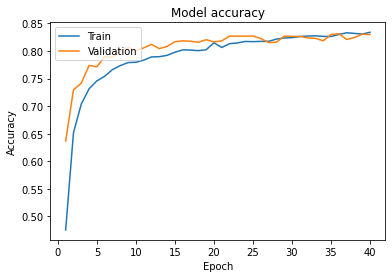

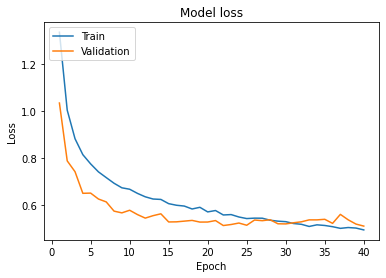

In [120]:
# Plot training & validation accuracy values
epoch_range = range(1, 41)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Model evaluation

In [121]:
# Model evaluation
test_loss, test_acc = model.evaluate(X_test,  y_test_cat, verbose=2)

135/135 - 1s - loss: 0.5102 - accuracy: 0.8300


## Prediction

In [122]:
# Prediction on test data
y_pred = model.predict_classes(X_test)

## Plot confusion matrix

In [123]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       738
           1       0.82      0.87      0.85       720
           2       0.87      0.89      0.88       723
           3       0.68      0.69      0.68       691
           4       0.93      0.87      0.90       752
           5       0.84      0.84      0.84       694

    accuracy                           0.83      4318
   macro avg       0.83      0.83      0.83      4318
weighted avg       0.83      0.83      0.83      4318



In [124]:
# Confusion matrix on test data
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_mat

array([[598,  21,   6,  50,  13,  50],
       [  9, 629,  10,  60,   5,   7],
       [  3,  16, 643,  44,   2,  15],
       [ 34,  82,  63, 474,  20,  18],
       [ 16,  15,   5,  44, 654,  18],
       [ 57,   5,  11,  26,   9, 586]])

(<Figure size 648x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1a926aec90>)

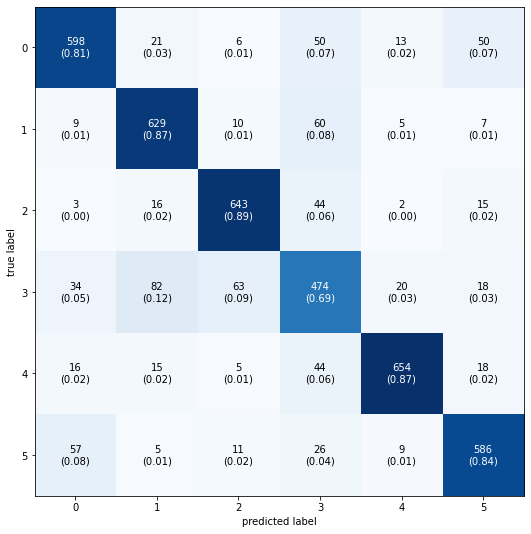

In [125]:
# Confusion matrix plot
plot_confusion_matrix(confusion_mat,figsize=(9,9), show_normed=True)